In [ ]:
import pandas as pd
import pdb
import re
import string
from sklearn.model_selection import train_test_split
from gensim import models
from keras.models import Sequential
from keras.models import Model
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import tensorflow as tf


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/DL_Final_Project_Akshada/

/content/drive/MyDrive/DL_Final_Project_Akshada


# **Data Preprocessing**

In [ ]:
dataset_final=pd.read_csv('FULL_Data_google_COVID_bull_bear.csv')

In [ ]:
dataset_final.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Open,High,Low,Close,Adj Close,Volume,MA7,MA21,MACD,20SD,upper_band,lower_band,EMA,logmomentum,absolute of 3 comp,angle of 3 comp,absolute of 6 comp,angle of 6 comp,absolute of 9 comp,angle of 9 comp,Date,search,COVID positiveIncrease,COVID deathIncrease,bull score,bear score,fourier bull 10,fourier bull 30,fourier bear 10,fourier bear 30
0,0,189,189,189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-07-01,17,0,0,0.000000,0.00,0.141086,0.147308,0.100437,0.101678
1,1,190,190,190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-07-02,17,0,0,0.200000,0.20,0.141930,0.147118,0.100488,0.100526
2,2,191,191,191,36.220001,36.325001,35.775002,35.875000,34.054882,57111200.0,36.173571,36.751904,0.303356,0.960520,38.672945,34.830864,35.924548,3.551770,38.458011,0.046984,29.704545,0.102857,43.304973,-0.053955,2017-07-03,15,0,0,0.666667,0.00,0.142778,0.146810,0.100537,0.099251
3,3,192,192,192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-07-04,15,0,0,0.000000,0.25,0.143631,0.146382,0.100585,0.097860
4,4,193,193,193,35.922501,36.197498,35.680000,36.022499,34.194897,86278400.0,36.095357,36.634762,0.328795,0.852735,38.340231,34.929292,35.989849,3.555991,38.240991,0.049445,29.954520,0.099254,43.438321,-0.053936,2017-07-05,15,0,0,0.400000,0.00,0.144487,0.145833,0.100630,0.096361


In [ ]:
dataset_final=dataset_final.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','Unnamed: 0.1.1.1'], axis=1)

In [ ]:
# Set the date to datetime data
datetime_series = pd.to_datetime(dataset_final['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset_final = dataset_final.set_index(datetime_index)
dataset_final = dataset_final.sort_values(by='Date')
dataset_final = dataset_final.drop(columns='Date')

In [ ]:
#counting null values
print (dataset_final.isnull().sum())

Open                      497
High                      497
Low                       497
Close                     497
Adj Close                 497
Volume                    497
MA7                       497
MA21                      497
MACD                      497
20SD                      497
upper_band                497
lower_band                497
EMA                       497
logmomentum               497
absolute of 3 comp        497
angle of 3 comp           497
absolute of 6 comp        497
angle of 6 comp           497
absolute of 9 comp        497
angle of 9 comp           497
search                      0
COVID positiveIncrease      0
COVID deathIncrease         0
bull score                 30
bear score                 30
fourier bull 10            47
fourier bull 30            47
fourier bear 10            47
fourier bear 30            47
dtype: int64


In [ ]:
corr_matrix = dataset_final.corr()
corr_matrix["Close"].sort_values(ascending=False)

Close                     1.000000
Adj Close                 0.999970
EMA                       0.999891
Low                       0.999721
High                      0.999719
Open                      0.999459
MA7                       0.998538
MA21                      0.994941
upper_band                0.993180
lower_band                0.991888
logmomentum               0.988550
absolute of 9 comp        0.981333
absolute of 6 comp        0.970917
absolute of 3 comp        0.942257
COVID positiveIncrease    0.736925
COVID deathIncrease       0.662235
20SD                      0.630682
search                    0.356932
fourier bull 30           0.068595
fourier bull 10           0.036715
bull score                0.009657
angle of 9 comp          -0.004130
bear score               -0.013307
angle of 6 comp          -0.016317
fourier bear 30          -0.082438
fourier bear 10          -0.146330
Volume                   -0.181519
angle of 3 comp          -0.228512
MACD                

In [ ]:
dataset_final.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'MA7', 'MA21',
       'MACD', '20SD', 'upper_band', 'lower_band', 'EMA', 'logmomentum',
       'absolute of 3 comp', 'angle of 3 comp', 'absolute of 6 comp',
       'angle of 6 comp', 'absolute of 9 comp', 'angle of 9 comp', 'search',
       'COVID positiveIncrease', 'COVID deathIncrease', 'bull score',
       'bear score', 'fourier bull 10', 'fourier bull 30', 'fourier bear 10',
       'fourier bear 30'],
      dtype='object')

In [ ]:
dataset_final=dataset_final.dropna()

In [ ]:
dataset_final.shape

(1080, 29)

### ***Generating training and test data***

In [ ]:
# Get features and target
X_value = pd.DataFrame(dataset_final.iloc[:, dataset_final.columns != "Close"])
y_value = pd.DataFrame(dataset_final.iloc[:, 3])

In [ ]:
y_value

,Close
2017-07-03,35.875000
2017-07-05,36.022499
2017-07-06,35.682499
2017-07-07,36.044998
2017-07-10,36.264999
...,...
2021-10-26,149.320007
2021-10-27,148.850006
2021-10-28,152.570007
2021-10-29,149.800003


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Normalized the data
X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
X_scaler.fit(X_value)
y_scaler.fit(y_value)

MinMaxScaler()

In [ ]:
X_scale_dataset = X_scaler.fit_transform(X_value)#shape 1080 X 28 - Consists of all features including the closing price
y_scale_dataset = y_scaler.fit_transform(y_value)#Shape 1080 X 1 - Consists of only the closing price

In [ ]:
y_scale_dataset.shape

(1080, 1)

In [ ]:
len(X_scale_dataset)

1080

In [ ]:
# Reshape the data
'''Set the data input steps and output steps, 
    we use 30 days data to predict 1 day price here, 
    reshape it to (None, input_step, number of features) used for LSTM input'''
n_steps_in = 3
n_features = X_value.shape[1]#28
n_steps_out = 1

# Get X/y dataset
def get_X_y(X_data, y_data):
    X = list()
    y = list()
    yc = list()

    length = len(X_data)#1080
    for i in range(0, length, 1):
        # pdb.set_trace()
        X_value = X_data[i: i + n_steps_in][:, :]
        y_value = y_data[i + n_steps_in: i + (n_steps_in + n_steps_out)][:, 0]
        yc_value = y_data[i: i + n_steps_in][:, :]
        if len(X_value) == 3 and len(y_value) == 1:
            X.append(X_value)#X will be a list of arrays of size 3 X 28 - features on previous 3 days
            y.append(y_value)#y will be a list of arrays of size 1 X 1 - next day
            yc.append(yc_value)#yc will be a list of arrays of size 3 X 1 - Closing price of the previous 3 days
    # pdb.set_trace()
    return np.array(X), np.array(y), np.array(yc)

In [ ]:
# get the train test predict index
def predict_index(dataset, X_train, n_steps_in, n_steps_out):
    # pdb.set_trace()
    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[n_steps_in : X_train.shape[0] + n_steps_in + n_steps_out - 1, :].index#dates starting from the 4th date in the original dataframe to the last date of the training set
    test_predict_index = dataset.iloc[X_train.shape[0] + n_steps_in:, :].index#dates starting from the 4th date from the end of the training data in the original dataframe to the last date in the original dataframe

    return train_predict_index, test_predict_index


In [ ]:
# Split train/test dataset
def split_train_test(data):
    
    train_size = round(len(X) * 0.7)
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [ ]:
# Get data and check shape
X, y, yc = get_X_y(X_scale_dataset, y_scale_dataset)#X will be of shape 1080 X 3 X 28 (each 3 X 28 array will be 3 days' worth of data). yc will have the corresponding closing price value
# pdb.set_trace()
X_train, X_test, = split_train_test(X)#X_train will be a 3d array consisting of 3 X 28 arrays , containing 70% of the original data and X_test will be a 3d array consisting of 3 X 28 arrays containing 30% of the original data
y_train, y_test, = split_train_test(y)#y_train will be a 3d array consisting of 1 X 1 arrays containing 70% of the original data and y_test will be a 3d array consisting of 1 X 1 arrays containing 30% of the original data
yc_train, yc_test, = split_train_test(yc)#yc_train will be a 3d array consisting of 3 X 1 arrays containing 70% of the original data and yc_test will be a 3d array consisting of 3 X 1 arrays containing 30% of the original data
index_train, index_test, = predict_index(dataset_final, X_train, n_steps_in, n_steps_out)

In [ ]:
# %% --------------------------------------- Shape of the dataset -----------------------------------------------------------------
print('X shape: ', X.shape)
print('y shape: ', y.shape)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('y_c_train shape: ', yc_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)
print('y_c_test shape: ', yc_test.shape)
print('index_train shape:', index_train.shape)
print('index_test shape:', index_test.shape)


X shape:  (1077, 3, 28)
y shape:  (1077, 1)
X_train shape:  (754, 3, 28)
y_train shape:  (754, 1)
y_c_train shape:  (754, 3, 1)
X_test shape:  (323, 3, 28)
y_test shape:  (323, 1)
y_c_test shape:  (323, 3, 1)
index_train shape: (754,)
index_test shape: (323,)


### ***Training a GRU model***

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional
from tensorflow.keras.layers import BatchNormalization, Embedding, TimeDistributed, LeakyReLU
from tensorflow.keras.layers import GRU, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from matplotlib import pyplot
from math import sqrt
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error

In [ ]:
X_train.shape

(754, 3, 28)

In [ ]:
LR = 0.0001
BATCH_SIZE = 20
N_EPOCH = 50

In [ ]:
input_dim = X_train.shape[1]#3
feature_size = X_train.shape[2]#28
output_dim = y_train.shape[1]#1

### ***Original model***

In [ ]:
def basic_GRU(input_dim, output_dim, feature_size) -> tf.keras.models.Model:
    model = Sequential()
    model.add(GRU(units=128, return_sequences = True, input_shape=(input_dim, feature_size)))  # 256, return_sequences = True
    model.add(GRU(units=64, input_shape=(input_dim, feature_size)))
    model.add(Dense(32))
    model.add(Dense(units=output_dim))
    model.compile(optimizer=Adam(lr=LR), loss='mse',metrics=['mae'])
    history = model.fit(X_train, y_train, epochs=N_EPOCH, batch_size=BATCH_SIZE, validation_data=(X_test, y_test),
                        verbose=2, shuffle=False)
    # pdb.set_trace()
    aaa=[round(num,3) for num in history.history['loss']]
    bbb=[round(num,3) for num in history.history['val_loss']]
    pyplot.plot([x for x in range(0,50)],aaa, label='train')
    pyplot.plot([x for x in range(0,50)],bbb, label='validation')
    pyplot.legend()
    pyplot.show()

    return model

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
38/38 - 5s - loss: 0.0037 - mae: 0.0536 - val_loss: 0.0924 - val_mae: 0.2920 - 5s/epoch - 132ms/step
Epoch 2/50
38/38 - 0s - loss: 0.0115 - mae: 0.0934 - val_loss: 0.0340 - val_mae: 0.1784 - 388ms/epoch - 10ms/step
Epoch 3/50
38/38 - 0s - loss: 0.0047 - mae: 0.0563 - val_loss: 0.0128 - val_mae: 0.1069 - 419ms/epoch - 11ms/step
Epoch 4/50
38/38 - 0s - loss: 0.0033 - mae: 0.0465 - val_loss: 0.0038 - val_mae: 0.0515 - 368ms/epoch - 10ms/step
Epoch 5/50
38/38 - 0s - loss: 0.0016 - mae: 0.0319 - val_loss: 0.0014 - val_mae: 0.0287 - 398ms/epoch - 10ms/step
Epoch 6/50
38/38 - 0s - loss: 6.5239e-04 - mae: 0.0208 - val_loss: 0.0015 - val_mae: 0.0309 - 378ms/epoch - 10ms/step
Epoch 7/50
38/38 - 0s - loss: 3.1653e-04 - mae: 0.0144 - val_loss: 0.0015 - val_mae: 0.0315 - 344ms/epoch - 9ms/step
Epoch 8/50
38/38 - 0s - loss: 2.4061e-04 - mae: 0.0123 - val_loss: 0.0016 - val_mae: 0.0324 - 351ms/epoch - 9ms/step
Epoch 9/50
38/38 - 0s - loss: 2.5629e-04 - mae: 0.0124 - val_loss: 0.0021 - val_

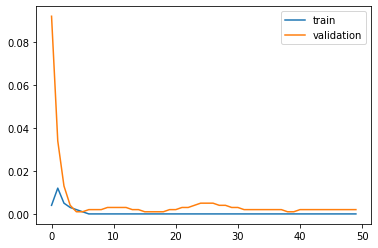

In [ ]:
model = basic_GRU(input_dim, output_dim, feature_size)


### ***Plotting the result***

### ***Train result***

In [ ]:
from sklearn.metrics import mean_absolute_error as mae

In [ ]:
def plot_realtraindataset_result(X_train,y_train):
  train_yhat=model.predict(X_train,verbose=0)#train_yhat will be the predicted values from 7 July 2017 to 20 July 2020
  # pdb.set_trace()
  rescaled_real_y=y_scaler.inverse_transform(y_train)#This will be the real closing price per day for train data from 7 July 2017 to 20 July 2020
  rescaled_predicted_y=y_scaler.inverse_transform(train_yhat)#This will be the predicted closing price per day for train data from 7 July 2017 to 20 July 2020

  predict_result=pd.DataFrame()

  for i in range(rescaled_predicted_y.shape[0]):#763
    y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=index_train[i:i + output_dim])
    predict_result=pd.concat([predict_result,y_predict],axis=1,sort=False)#This will be a dataframe with each column showing the predicted closing price for a single day 
  # pdb.set_trace()
  real_result=pd.DataFrame()

  for i in range(rescaled_real_y.shape[0]):
    y_real = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                                 index=index_train[i:i + output_dim])
    real_result=pd.concat([real_result,y_real],axis=1,sort=False)#This will be a dataframe with each column showing the real closing price for a single day 
  # pdb.set_trace()
  predict_result['predicted_mean'] = predict_result.mean(axis=1)#The last column of the dataframe will show the daily predicted closing price from 7 July 2017 to 20 July 2020
  real_result['real_mean'] = real_result.mean(axis=1)#The last column of the dataframe will show the daily real closing price from 7 July 2017 to 20 July 2020

  # Plot the predicted result
  plt.figure(figsize=(16, 8))
  plt.plot(real_result["real_mean"])
  plt.plot(predict_result["predicted_mean"], color='r')
  plt.xlabel("Date")
  plt.ylabel("Stock price")
  plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
  plt.title("The result of Train for GRU Model - FULL Data", fontsize=20)
  plt.show()

  # Calculate RMSE
  predicted = predict_result["predicted_mean"]
  real = real_result["real_mean"]
  For_MSE = pd.concat([predicted, real], axis=1)
  MSE = (mean_squared_error(predicted, real))
  RMSE = np.sqrt(mean_squared_error(predicted, real))
  MAE=mae(predicted, real)
  #print('-- Train RMSE -- ', RMSE)

  return MSE,RMSE,MAE

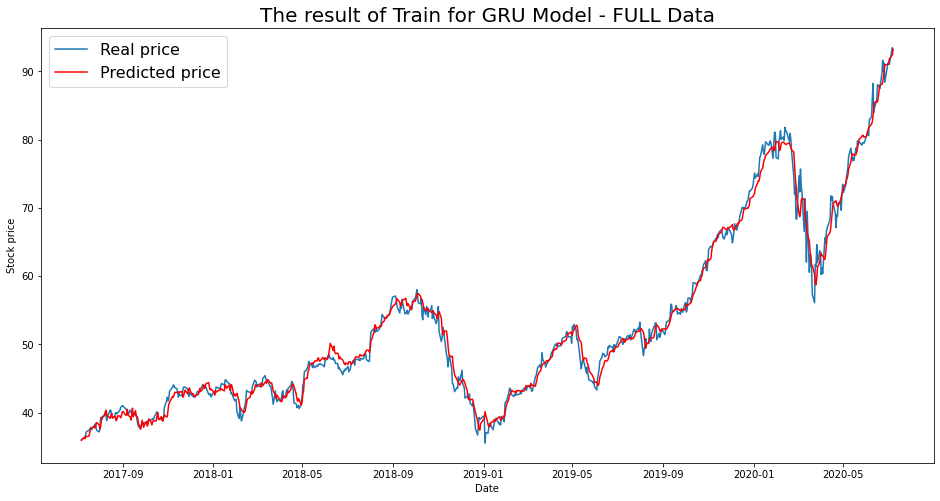

----- Train_MSE_LSTM ----- 1.7316788134485017
----- Train_RMSE_LSTM ----- 1.3159326781596776
----- Train_mae_LSTM ----- 0.956026019937935


In [ ]:
train_MSE,train_RMSE,train_MAE = plot_realtraindataset_result(X_train, y_train)
print("----- Train_MSE_LSTM -----", train_MSE)
print("----- Train_RMSE_LSTM -----", train_RMSE)
print("----- Train_mae_LSTM -----", train_MAE)

### ***Test result***

In [ ]:
def plot_testdataset_result(X_test, y_test):
    test_yhat = model.predict(X_test, verbose=0)


    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(test_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=index_test[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):

        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=index_test[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)
    # pdb.set_trace()

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Testing GRU Model - FULL Data", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    MSE = (mean_squared_error(predicted, real))
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    MAE=mae(predicted, real)

    return MSE,RMSE,MAE


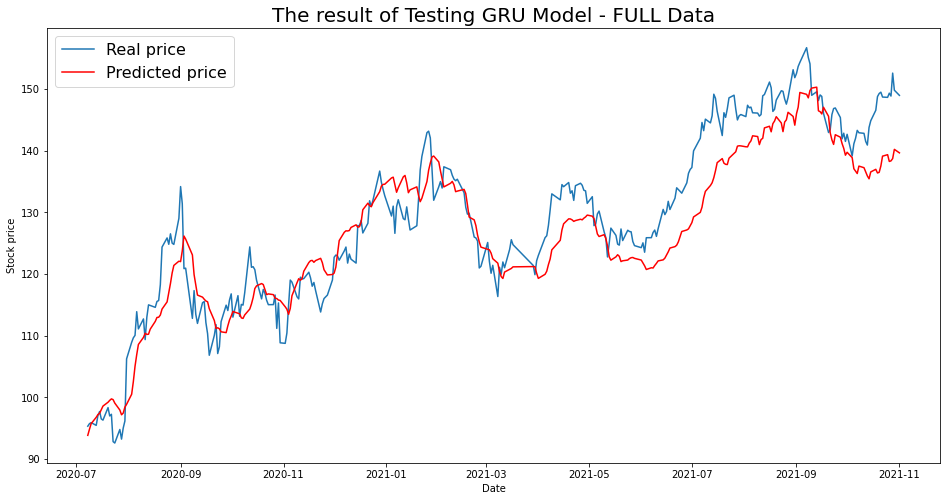

----- test_MSE_LSTM ----- 29.285379717159714
----- test_RMSE_LSTM ----- 5.411596780725604
----- test_MAE_LSTM ----- 4.4591727129979555


In [ ]:
test_MSE,test_RMSE,test_MAE = plot_testdataset_result(X_test, y_test)
print("----- test_MSE_LSTM -----", test_MSE)
print("----- test_RMSE_LSTM -----", test_RMSE)
print("----- test_MAE_LSTM -----", test_MAE)

###***Analysis using baseline LSTM model***

In [ ]:

BATCH_SIZE = 20


In [ ]:
input_dim = X_train.shape[1]#3
feature_size = X_train.shape[2]#29
output_dim = y_train.shape[1]#1


### ***LSTM model***

In [ ]:
def basic_lstm(hp):
    model = Sequential()
    model.add(LSTM(units= 64, input_shape=(input_dim, feature_size)))
    model.add(Dense(32))
    model.add(Dense(units=output_dim))

    hp_learning_rate=hp.Choice('learning_rate',values=[0.0001,0.001,0.01])#defining the hyperparameters

    model.compile(optimizer=Adam(lr = hp_learning_rate), loss='mse')

    return model

### ***Running with keras tuner***

In [ ]:
pip install keras-tuner

     |████████████████████████████████| 98 kB 3.6 MB/s 


In [ ]:
from tensorflow import keras
import keras_tuner as kt

In [ ]:
tuner=kt.BayesianOptimization(basic_lstm,objective='val_loss',max_trials=3,directory='my_dir_tuner28',seed=1337)#Instantiate the keras tuner

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)#Creating the early stopping callback

tuner.search(X_train, y_train,validation_data=(X_test, y_test),epochs=70,batch_size=BATCH_SIZE,callbacks=[stop_early])#Running hyperparameter search : goes to the model architecture

Trial 3 Complete [00h 00m 08s]
val_loss: 0.003117042127996683

Best val_loss So Far: 0.003117042127996683
Total elapsed time: 00h 00m 25s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]#Extracting the best hyperparameters
print(f"""
The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The optimal learning rate for the optimizer
is 0.0001.



In [ ]:
model = tuner.hypermodel.build(best_hps)#goes to the model architecture. Build model with best hyperparameters
history = model.fit(X_train, y_train,epochs=200,batch_size=BATCH_SIZE, validation_data=(X_test, y_test),
                        verbose=2, shuffle=False,callbacks=[stop_early])#Train the model using the best hyperparameters, and use early stopping

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/200
38/38 - 3s - loss: 0.0264 - val_loss: 0.2721 - 3s/epoch - 69ms/step
Epoch 2/200
38/38 - 0s - loss: 0.0069 - val_loss: 0.1589 - 205ms/epoch - 5ms/step
Epoch 3/200
38/38 - 0s - loss: 0.0043 - val_loss: 0.1110 - 187ms/epoch - 5ms/step
Epoch 4/200
38/38 - 0s - loss: 0.0031 - val_loss: 0.0718 - 209ms/epoch - 6ms/step
Epoch 5/200
38/38 - 0s - loss: 0.0024 - val_loss: 0.0480 - 194ms/epoch - 5ms/step
Epoch 6/200
38/38 - 0s - loss: 0.0018 - val_loss: 0.0328 - 196ms/epoch - 5ms/step
Epoch 7/200
38/38 - 0s - loss: 0.0014 - val_loss: 0.0230 - 197ms/epoch - 5ms/step
Epoch 8/200
38/38 - 0s - loss: 0.0011 - val_loss: 0.0166 - 197ms/epoch - 5ms/step
Epoch 9/200
38/38 - 0s - loss: 8.8826e-04 - val_loss: 0.0123 - 167ms/epoch - 4ms/step
Epoch 10/200
38/38 - 0s - loss: 7.3850e-04 - val_loss: 0.0095 - 147ms/epoch - 4ms/step
Epoch 11/200
38/38 - 0s - loss: 6.3633e-04 - val_loss: 0.0077 - 196ms/epoch - 5ms/step
Epoch 12/200
38/38 - 0s - loss: 5.6528e-04 - val_loss: 0.0066 - 157ms/epoch - 4ms/step

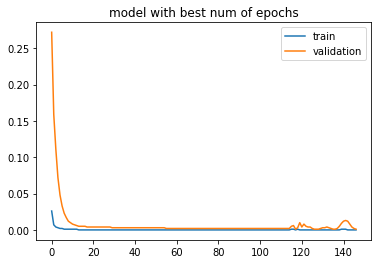

In [ ]:
# pdb.set_trace()
aaa=[round(num,3) for num in history.history['loss']]
bbb=[round(num,3) for num in history.history['val_loss']]
# pdb.set_trace()
pyplot.plot([x for x in range(0,147)],aaa, label='train')
pyplot.plot([x for x in range(0,147)],bbb, label='validation')
pyplot.legend()
pyplot.title('model with best num of epochs')
pyplot.show()

### ***Plot train result***

In [ ]:
def plot_traindataset_result(X_train, y_train):


    train_yhat = model.predict(X_train, verbose=0)#Predicted (scaled) closing price for train set. 

    rescaled_real_y = y_scaler.inverse_transform(y_train)#Real closing price data
    rescaled_predicted_y = y_scaler.inverse_transform(train_yhat)#Predicted closing price data

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=index_train[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)#This is a dataframe with each column containing the predicted daily closing price of the 4th day
    # pdb.set_trace()
    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=index_train[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)#This is a dataframe with each column containing the real daily closing price
    # pdb.set_trace()
    predict_result['predicted_mean'] = predict_result.mean(axis=1)#Adding a column with the daily predicted closing price value
    real_price['real_mean'] = real_price.mean(axis=1)#Adding a column with the daily real closing price value
    #
    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Training", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    MSE = (mean_squared_error(predicted, real))
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    MAE=mae(predicted, real)
    #print('-- Train RMSE -- ', RMSE)

    return MSE,RMSE,MAE

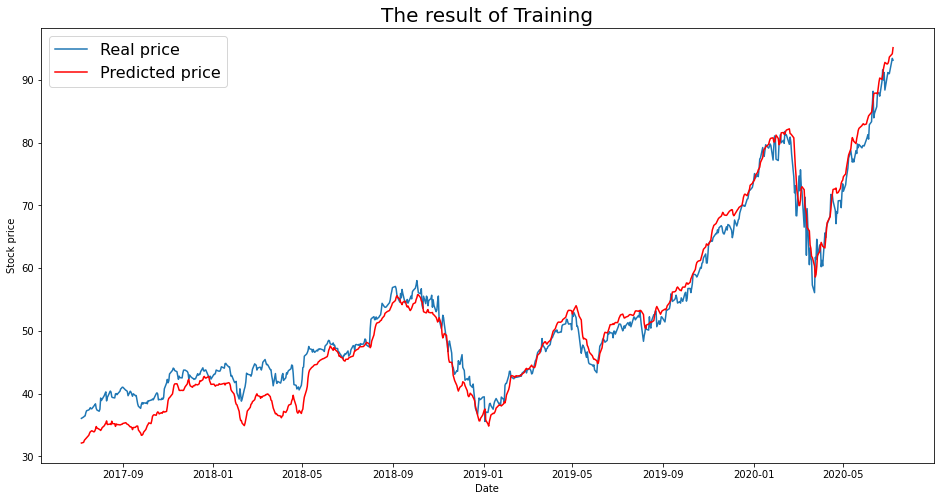

----- Train_MSE_LSTM ----- 7.338199018818721
----- Train_RMSE_LSTM ----- 2.708911039295813
----- Train_MAE_LSTM ----- 2.1666730742802707


In [ ]:
train_MSE,train_RMSE,train_MAE = plot_traindataset_result(X_train, y_train)
print("----- Train_MSE_LSTM -----", train_MSE)
print("----- Train_RMSE_LSTM -----", train_RMSE)
print("----- Train_MAE_LSTM -----", train_MAE)

In [ ]:
def plot_testdataset_result(X_test, y_test):

    test_yhat = model.predict(X_test, verbose=0)

    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(test_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=index_test[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=index_test[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)


    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Testing LSTM Model - FULL Data", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    MSE = (mean_squared_error(predicted, real))
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    MAE=mae(predicted, real)

    return MSE,RMSE,MAE


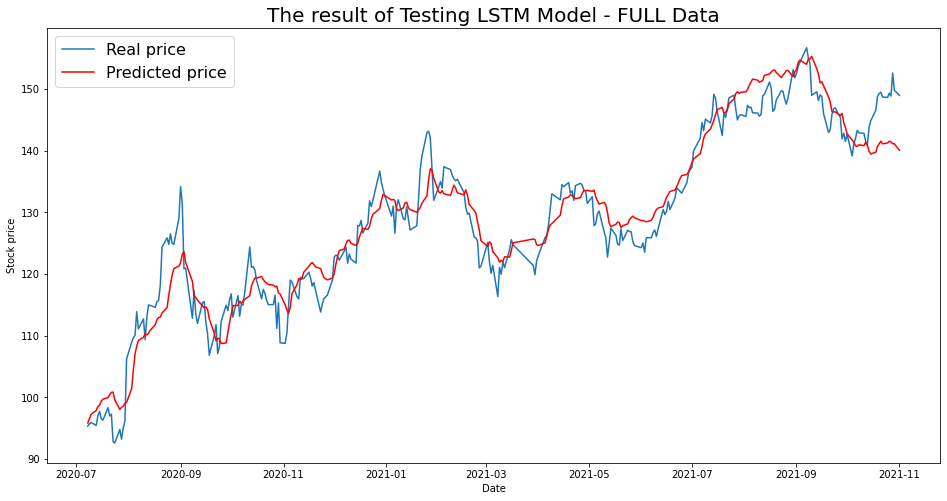

----- test_MSE_LSTM ----- 14.753368579587033
----- test_RMSE_LSTM ----- 3.84101140060623
----- test_MAE_LSTM ----- 3.040393588333555


In [ ]:
# test_RMSE = plot_testdataset_result(X_test, y_test)
test_MSE,test_RMSE,test_MAE = plot_testdataset_result(X_test, y_test)
print("----- test_MSE_LSTM -----", test_MSE)
print("----- test_RMSE_LSTM -----", test_RMSE)
print("----- test_MAE_LSTM -----", test_MAE)

### ***Implementing basic GAN***

In [ ]:
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
import os

In [ ]:
def make_generator_model(input_dim, output_dim, feature_size) -> tf.keras.models.Model:

    model = Sequential()
    model.add(GRU(units=1024, return_sequences = True, input_shape=(input_dim, feature_size),
                  recurrent_dropout=0.2))
    model.add(GRU(units=512, return_sequences = True, recurrent_dropout=0.2)) # 256, return_sequences = True
    model.add(GRU(units=256, recurrent_dropout=0.2)) #, recurrent_dropout=0.1
    # , recurrent_dropout = 0.2
    model.add(Dense(128))
    model.add(Dense(64))
    model.add(Dense(units=output_dim))
    return model

In [ ]:
def make_discriminator_model():

    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(32, input_shape=(4, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(128, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Flatten())
    cnn_net.add(Dense(220, use_bias=False))
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))
    cnn_net.add(Dense(1, activation='sigmoid'))
    return cnn_net

In [ ]:
model = make_discriminator_model()
plot_model(model,to_file='gan.png')
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 32)             128       
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             10304     
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 128)            41088     
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 220)               28160     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 220)               0         
                                                                 
 dense_5 (Dense)             (None, 220)              

### ***GAN Class***

In [ ]:
class GAN:
    def __init__(self, generator, discriminator, opt):
        # pdb.set_trace()

        self.opt = opt
        self.lr = opt["lr"]
        self.generator = generator
        self.discriminator = discriminator
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.generator_optimizer = tf.keras.optimizers.Adam(lr=self.lr)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(lr=self.lr)
        self.batch_size = self.opt['bs']


    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return real_loss, fake_loss, total_loss

    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    @tf.function
    def train_step(self, real_x, real_y, yc):#Generating real price, fake price and loss
        # pdb.set_trace()

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # pdb.set_trace()
            z=tf.random.normal([real_x.shape[0]*real_x.shape[1]*(real_x.shape[2]-1)])
            z_reshape = tf.reshape(z, [real_x.shape[0],real_x.shape[1],(real_x.shape[2]-1)])#new shape will be 754 X 3 X 27
            z_reshape= tf.cast(z_reshape, tf.float64)
            gen_input = tf.concat([z_reshape, yc], axis=2)#shape will be 754 X 3 X 28
            generated_data = self.generator(gen_input, training=True)#shape will be 754 X 1
            generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])#new shape will be 754 X 1 X 1
            d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)#shape will be 754 X 4 X 1
            real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
            # pdb.set_trace()
            d_real_input = tf.concat([real_y_reshape, yc], axis=1)

            real_output = self.discriminator(d_real_input, training=True)#shape 754 X 1
            fake_output = self.discriminator(d_fake_input, training=True)#shape 754 X 1

            gen_loss = self.generator_loss(fake_output)
            disc_loss_real,disc_loss_fake,disc_loss = self.discriminator_loss(real_output, fake_output)
        # pdb.set_trace()
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(
            zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        # pdb.set_trace()
        return real_y, generated_data, {'d_loss_real': disc_loss_real, 'd_loss_fake': disc_loss_fake, 'g_loss': gen_loss}

    @tf.function
    def test_step(self, real_x, real_y, yc):
        # pdb.set_trace()
        z=tf.random.normal([real_x.shape[0]*real_x.shape[1]*(real_x.shape[2]-1)])
        z_reshape = tf.reshape(z, [real_x.shape[0],real_x.shape[1],(real_x.shape[2]-1)])#new shape will be 754 X 3 X 27
        z_reshape= tf.cast(z_reshape, tf.float64)
        gen_input = tf.concat([z_reshape, yc], axis=2)#shape will be 754 X 3 X 28
        generated_data = self.generator(gen_input)
        generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
        d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
        real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
        d_real_input = tf.concat([real_y_reshape, yc], axis=1)

        real_output = self.discriminator(d_real_input, training=True)
        fake_output = self.discriminator(d_fake_input, training=True)

        gen_loss = self.generator_loss(fake_output)
        disc_loss_real,disc_loss_fake,disc_loss = self.discriminator_loss(real_output, fake_output)

        return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': gen_loss}


    def train(self, real_x, real_y, yc, opt):

        train_hist = {}
        train_hist['D_real_losses'] = []
        train_hist['D_fake_losses'] = []
        train_hist['G_losses'] = []
        train_hist['per_epoch_times'] = []
        train_hist['total_ptime'] = []

        epochs = opt["epoch"]
        for epoch in range(epochs):#At the end of the for loop, we will get
        #D_losses : list of n=epochs elements with each element = disc loss
        #G_losses : list of n=epochs elements with each element = generator loss
        #Predicted_price : list of n=epochs elements with each element of size 754 X 1

            start = time.time()

            real_price, fake_price, loss = self.train_step(real_x, real_y, yc)

            G_losses = []
            D_real_losses = []
            D_fake_losses = []

            Real_price = []
            Predicted_price = []

            D_real_losses.append(loss['d_loss_real'].numpy())
            D_fake_losses.append(loss['d_loss_fake'].numpy())
            G_losses.append(loss['g_loss'].numpy())

            Predicted_price.append(fake_price.numpy())
            Real_price.append(real_price.numpy())

            # Save the model every 15 epochs
            if (epoch + 1) % 15 == 0:

                print('epoch', epoch + 1, 'd_loss_real', loss['d_loss_real'].numpy(), 'g_loss', loss['g_loss'].numpy())
            # For printing loss
            epoch_end_time = time.time()
            per_epoch_ptime = epoch_end_time - start
            train_hist['D_real_losses'].append(D_real_losses)
            train_hist['D_fake_losses'].append(D_fake_losses)
            train_hist['G_losses'].append(G_losses)
            train_hist['per_epoch_times'].append(per_epoch_ptime)

        # Reshape the predicted result & real
        Predicted_price = np.array(Predicted_price)
        Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
        Real_price = np.array(Real_price)
        Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

        plt.plot(train_hist['D_real_losses'], label='D_loss_real')
        plt.plot(train_hist['D_fake_losses'], label='D_loss_fake')
        plt.plot(train_hist['G_losses'], label='G_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        # pdb.set_trace()
        return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(
            Real_price)


    def test(self, real_x, real_y, yc, opt):
        # pdb.set_trace()


        real_price, fake_price, loss = self.test_step(real_x, real_y, yc)

        G_losses = []
        D_losses = []

        Real_price = []
        Predicted_price = []
        # pdb.set_trace()
        D_losses.append(loss['d_loss'].numpy())
        G_losses.append(loss['g_loss'].numpy())

        Predicted_price.append(fake_price.numpy())
        Real_price.append(real_price.numpy())


        # Reshape the predicted result & real
        Predicted_price = np.array(Predicted_price)
        Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
        Real_price = np.array(Real_price)
        Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])


        return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(
            Real_price)


In [ ]:
import time


In [ ]:
y_train.shape


(1, 1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


epoch 15 d_loss_real 0.69150686 g_loss 0.6914139
epoch 30 d_loss_real 0.69336075 g_loss 0.696491
epoch 45 d_loss_real 0.69304925 g_loss 0.6927121
epoch 60 d_loss_real 0.6902984 g_loss 0.69227695
epoch 75 d_loss_real 0.69025606 g_loss 0.6902839
epoch 90 d_loss_real 0.6947539 g_loss 0.6971348
epoch 105 d_loss_real 0.69276273 g_loss 0.6957388
epoch 120 d_loss_real 0.690163 g_loss 0.691659
epoch 135 d_loss_real 0.69296694 g_loss 0.69394517
epoch 150 d_loss_real 0.691245 g_loss 0.69149244
epoch 165 d_loss_real 0.69402146 g_loss 0.6942948
epoch 180 d_loss_real 0.69295764 g_loss 0.69316965
epoch 195 d_loss_real 0.69309604 g_loss 0.6932264
epoch 210 d_loss_real 0.6931322 g_loss 0.69325113
epoch 225 d_loss_real 0.6928514 g_loss 0.69292283
epoch 240 d_loss_real 0.69346315 g_loss 0.69343513


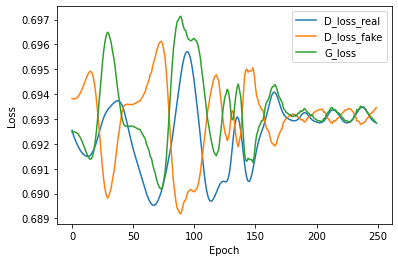

In [ ]:
if __name__ == '__main__':
    input_dim = X_train.shape[1]#3
    feature_size = X_train.shape[2]#28
    output_dim = y_train.shape[1]#1

    ## For Bayesian
    opt = {"lr": 0.0001, "epoch": 250, 'bs': 20}

    generator = make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
    discriminator = make_discriminator_model()
    gan = GAN(generator, discriminator, opt)
    Predicted_price, Real_price, RMSPE = gan.train(X_train, y_train, yc_train, opt)




----- predicted price ----- [[-0.00153987]
 [ 0.00353591]
 [ 0.00513728]
 [ 0.00783169]
 [ 0.01133756]
 [ 0.0246844 ]
 [ 0.02931889]
 [ 0.03511798]
 [ 0.02225649]
 [ 0.01564621]
 [ 0.03124675]
 [ 0.02696075]
 [ 0.02661354]
 [ 0.02660901]
 [ 0.02141887]
 [ 0.0082147 ]
 [ 0.02178305]
 [ 0.02076116]
 [ 0.02019658]
 [ 0.02096741]
 [ 0.03040058]
 [ 0.04503546]
 [ 0.04190189]
 [ 0.0281263 ]
 [ 0.05066341]
 [ 0.04816446]
 [ 0.04819377]
 [ 0.04719923]
 [ 0.04192534]
 [ 0.0497288 ]
 [ 0.04508602]
 [ 0.04262617]
 [ 0.04378969]
 [ 0.0355105 ]
 [ 0.04536514]
 [ 0.03737486]
 [ 0.0505015 ]
 [ 0.04602142]
 [ 0.04261687]
 [ 0.04653011]
 [ 0.05739254]
 [ 0.05302696]
 [ 0.04097597]
 [ 0.03185575]
 [ 0.04040868]
 [ 0.05682124]
 [ 0.02901022]
 [ 0.03839365]
 [ 0.04351173]
 [ 0.03598587]
 [ 0.03910183]
 [ 0.02831227]
 [ 0.03384723]
 [ 0.02857467]
 [ 0.03615568]
 [ 0.01640731]
 [ 0.02373625]
 [ 0.00574978]
 [ 0.02643481]
 [ 0.03859944]
 [ 0.01729691]
 [ 0.03295586]
 [ 0.01065867]
 [ 0.03813082]
 [ 0.0397274

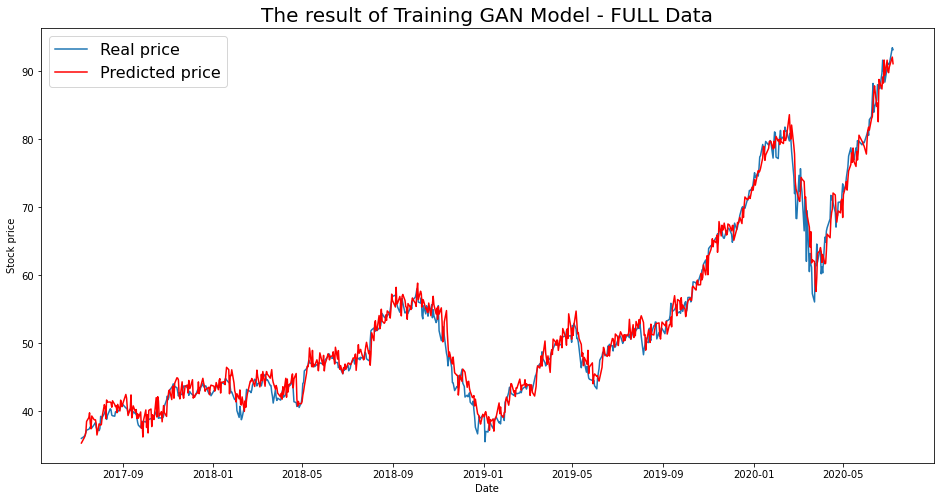

----- Train_MSE_GAN ----- 2.6482063843195265
----- Train_RMSE_GAN ----- 1.6273310616833707
----- Train_MAE_GAN ----- 1.2076961923339196


In [ ]:
train_predict_index = np.load("index_train.npy", allow_pickle=True)
test_predict_index = np.load("index_test.npy", allow_pickle=True)


print("----- predicted price -----", Predicted_price)

rescaled_Real_price = y_scaler.inverse_transform(Real_price)
rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

print("----- rescaled predicted price -----", rescaled_Predicted_price)
print("----- SHAPE rescaled predicted price -----", rescaled_Predicted_price.shape)

predict_result = pd.DataFrame()
for i in range(rescaled_Predicted_price.shape[0]):
    y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=index_train[i:i+output_dim])
    predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)
#
real_price = pd.DataFrame()
for i in range(rescaled_Real_price.shape[0]):
    y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=index_train[i:i+output_dim])
    real_price = pd.concat([real_price, y_train], axis=1, sort=False)

predict_result['predicted_mean'] = predict_result.mean(axis=1)
real_price['real_mean'] = real_price.mean(axis=1)

# Plot the predicted result
plt.figure(figsize=(16, 8))
plt.plot(real_price["real_mean"])
plt.plot(predict_result["predicted_mean"], color = 'r')
plt.xlabel("Date")
plt.ylabel("Stock price")
plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
plt.title("The result of Training GAN Model - FULL Data", fontsize=20)
plt.show()

# Calculate RMSE
predicted = predict_result["predicted_mean"]
real = real_price["real_mean"]
For_MSE = pd.concat([predicted, real], axis = 1)
MSE = (mean_squared_error(predicted, real))
RMSE = np.sqrt(mean_squared_error(predicted, real))
MAE=mae(predicted, real)
#print('-- Train RMSE -- ', RMSE)
print("----- Train_MSE_GAN -----", MSE)
print("----- Train_RMSE_GAN -----", RMSE)
print("----- Train_MAE_GAN -----", MAE)


In [ ]:
Predicted_price, Real_price, RMSPE = gan.test(X_test, y_test, yc_test, opt)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


----- predicted price ----- [[0.46841845]
 [0.503989  ]
 [0.4973409 ]
 [0.5140645 ]
 [0.50947094]
 [0.50956756]
 [0.51309484]
 [0.51714283]
 [0.52266455]
 [0.5217955 ]
 [0.5178915 ]
 [0.52170056]
 [0.5127702 ]
 [0.505856  ]
 [0.4908087 ]
 [0.48687473]
 [0.50184065]
 [0.5022862 ]
 [0.51763743]
 [0.56679296]
 [0.61173904]
 [0.60898787]
 [0.63092357]
 [0.64344186]
 [0.6414756 ]
 [0.63375205]
 [0.64471984]
 [0.64202124]
 [0.6720521 ]
 [0.658254  ]
 [0.65654504]
 [0.6767288 ]
 [0.6706414 ]
 [0.70054084]
 [0.7292358 ]
 [0.7586803 ]
 [0.7394556 ]
 [0.7567558 ]
 [0.76214266]
 [0.7563813 ]
 [0.7853875 ]
 [0.8227647 ]
 [0.7997433 ]
 [0.7584286 ]
 [0.7033672 ]
 [0.69268435]
 [0.67540306]
 [0.66949576]
 [0.65451586]
 [0.66488665]
 [0.66979975]
 [0.6461575 ]
 [0.62950975]
 [0.60815024]
 [0.6079119 ]
 [0.62865126]
 [0.61472183]
 [0.61862427]
 [0.64206964]
 [0.66437346]
 [0.66683227]
 [0.6695999 ]
 [0.667338  ]
 [0.67505825]
 [0.63852876]
 [0.66751134]
 [0.66074586]
 [0.67776954]
 [0.6841191 ]
 [0.71

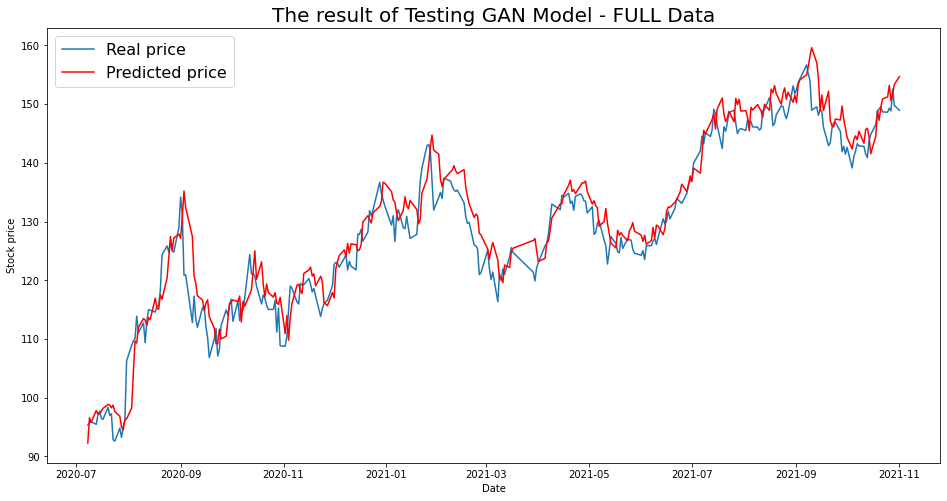

----- test_MSE_GAN ----- 14.03588983554917
----- test_RMSE_GAN ----- 3.746450298022005
----- test_MAE_GAN ----- 2.8773490073136365


In [ ]:
train_predict_index = np.load("index_train.npy", allow_pickle=True)
test_predict_index = np.load("index_test.npy", allow_pickle=True)

print("----- predicted price -----", Predicted_price)

rescaled_Real_price = y_scaler.inverse_transform(Real_price)
rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

print("----- rescaled predicted price -----", rescaled_Predicted_price)
print("----- SHAPE rescaled predicted price -----", rescaled_Predicted_price.shape)

predict_result = pd.DataFrame()
for i in range(rescaled_Predicted_price.shape[0]):
    y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=index_test[i:i+output_dim])
    predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)
#
real_price = pd.DataFrame()
for i in range(rescaled_Real_price.shape[0]):
    y_test = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=index_test[i:i+output_dim])
    real_price = pd.concat([real_price, y_test], axis=1, sort=False)

predict_result['predicted_mean'] = predict_result.mean(axis=1)
real_price['real_mean'] = real_price.mean(axis=1)

# Plot the predicted result
plt.figure(figsize=(16, 8))
plt.plot(real_price["real_mean"])
plt.plot(predict_result["predicted_mean"], color = 'r')
plt.xlabel("Date")
plt.ylabel("Stock price")
plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
plt.title("The result of Testing GAN Model - FULL Data", fontsize=20)
plt.show()

# Calculate RMSE
predicted = predict_result["predicted_mean"]
real = real_price["real_mean"]
For_MSE = pd.concat([predicted, real], axis = 1)
MSE = (mean_squared_error(predicted, real))
RMSE = np.sqrt(mean_squared_error(predicted, real))
MAE=mae(predicted, real)
print("----- test_MSE_GAN -----", MSE)
print("----- test_RMSE_GAN -----", RMSE)
print("----- test_MAE_GAN -----", MAE)

In [ ]:
real=rescaled_Real_price
pred=rescaled_Predicted_price
df = pd.DataFrame()
df['Real Closing Price']=real.tolist()
df['Predicted Closing Price']=pred.tolist()

In [ ]:
df.head(10)

,Real Closing Price,Predicted Closing Price
0,[95.342499],[92.29288482666016]
1,[95.752502],[96.60198211669922]
2,[95.91999799999999],[95.79662322998047]
3,[95.477501],[97.82255554199219]
4,[97.057503],[97.26608276367188]
5,[97.724998],[97.27778625488281]
6,[96.522499],[97.70509338378906]
7,[96.327499],[98.19547271728516]
8,[98.35749799999999],[98.86438751220703]
9,[97.0],[98.75910949707031]
